In [53]:
pip install contextily --quiet

Note: you may need to restart the kernel to use updated packages.


In [144]:
pip install piecewise_regression --quiet

Note: you may need to restart the kernel to use updated packages.


In [148]:
import rasterstats
from rasterstats import zonal_stats
import rasterio
import rioxarray as rxr
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as cx
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import piecewise_regression as pwr

In [2]:
spatial_path = "/Users/markos98/aquasteady_research/data/spatial/"
shape_path = "/Users/markos98/aquasteady_research/data/spatial/CA_shapefiles/"
raw_path = "/Users/markos98/aquasteady_research/data/raw/"
transformed_path = "/Users/markos98/aquasteady_research/data/transformed/"

In [9]:
with rasterio.open(spatial_path + "california.tif") as src:
    spi_data = src.read(1)  
    bounds = src.bounds     
    crs = src.crs

In [11]:
watersheds = gpd.read_file(shape_path + "WBDHU6.shp")
watersheds = CA_watersheds.to_crs(crs)  # Match CRS to SPI data

In [6]:
convex_hull = CA_watersheds[['geometry']].dissolve().convex_hull

In [7]:
convex_hull = gpd.GeoDataFrame(geometry=convex_hull)

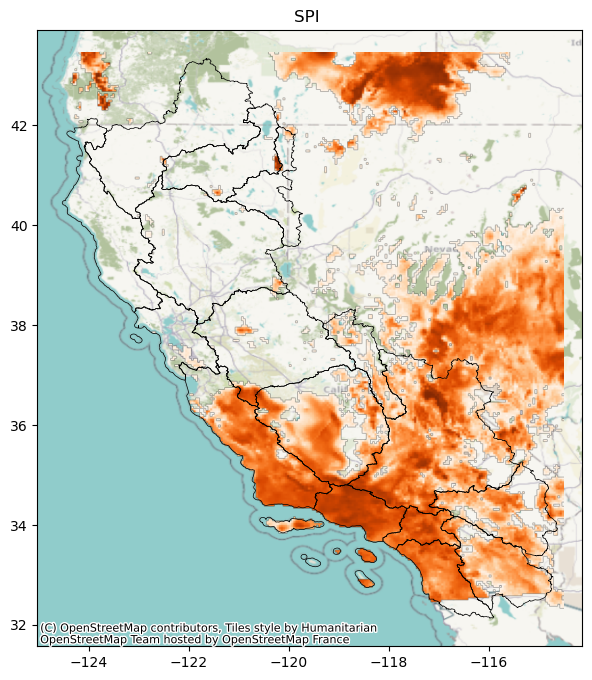

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))

# Overlay watershed boundaries
CA_watersheds.boundary.plot(ax=ax, linewidth=0.5, color="black")

# convex_hull.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, linestyle='--', label='Convex Hull')

# basemap = cx.providers.Stadia.TerrainBackground

cx.add_basemap(ax, crs = CA_watersheds.crs.to_string())

show(spi_data, ax=ax, transform=src.transform, cmap="Oranges", alpha=1.0)

# Add USDA irrigation data (if available)
# Example: Color watersheds by irrigation acres
# CA_watersheds.plot(ax=ax, column="Irrigated_Acres", legend=True, alpha=0.3)

plt.title("SPI")
plt.show()

In [6]:
with rasterio.open(spatial_path + "california.tif") as src:
    spi_array = src.read(1)  # NumPy array
    affine_transform = src.transform  # Affine transform

In [41]:
spi_stats = rasterstats.zonal_stats(
    watersheds, 
    spi_array,
    affine=affine_transform,
    stats=["mean"], 
    geojson_out=True
)

In [42]:
spi = gpd.GeoDataFrame.from_features(spi_stats)

In [56]:
print("SPI HUC6:", spi["huc6"].unique())

SPI HUC6: ['180600' '180800' '180703' '180101' '180701' '180901' '180500' '180200'
 '180702' '181002' '180400' '180102' '180201' '180300' '180902' '181001']


In [87]:
usda22 = pd.read_csv(transformed_path + "usda 2022.csv")

In [88]:
spi['huc6'] = spi['huc6'].astype(np.int64)

In [128]:
merged = usda22.merge(
    spi, 
    on="huc6",      # Links each SPI value to both 2017 and 2022 USDA rows
    how="left"      # Keeps all USDA rows, even if SPI is missing
)

print(f"Merged rows: {len(merged)}") 

Merged rows: 16


In [129]:
ca_avg_spi = spi["mean"].mean()
merged["mean"] = merged["mean"].fillna(ca_avg_spi)

In [130]:
merged.head()

,huc6,Year,Land in farms,Total cropland,Harvested cropland,Other pasture and grazing land that could have been used for crops without additional improvement,Cropland idle or used for cover crops or soil-improvement but not harvested and not pastured or grazed,Cropland on which all crops failed or were abandoned,Cropland in summer fallow,Total woodland,...,loaddate,referenceg,areaacres,areasqkm,states,name,shape_Leng,shape_Area,ObjectID,mean
0,180101,2022,1584901,163380,111505,31937,15490,2696,1752,504906,...,2022-03-16,None,6703510.29,27128.17,"CA,OR",Northern California Coastal,None,None,4,0.838079
1,180102,2022,1216990,333751,234108,28496,39737,16691,14719,152675,...,2024-08-16,277534,10040760.31,40633.55,"CA,OR",Klamath,None,None,12,0.314958
2,180200,2022,790413,165638,111711,25455,21010,2845,4617,78174,...,2024-08-16,1654949,4914813.15,19889.56,"CA,OR",Upper Sacramento,None,None,8,1.021672
3,180201,2022,3956840,1685465,1242597,67056,149953,65767,160092,285743,...,2024-08-16,1654949,12880011.17,52123.60,CA,Lower Sacramento,None,None,13,0.316029
4,180300,2022,5411004,3099231,2537697,93742,276592,52461,138739,66561,...,2024-08-16,"1652803,690469",10501344.46,42497.47,CA,Tulare-Buena Vista Lakes,None,None,14,0.833101


In [131]:
merged.to_csv('merged.csv', index=True)

In [132]:
merged.rename(columns={'Cropland on which all crops failed or were abandoned': 
                     'total_crop_failure'}, inplace=True)

In [153]:
formula = "mean ~ total_crop_failure"

In [154]:
model = smf.ols(formula, data=merged).fit()

In [155]:
model.summary()

/Volumes/Mac/opt/anaconda3/envs/aquasteady/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     5.334
Date:                Sun, 11 May 2025   Prob (F-statistic):              0.328
Time:                        16:40:51   Log-Likelihood:                 25.886
No. Observations:                  16   AIC:                            -21.77
Df Residuals:                       1   BIC:                            -10.18
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.8973      0.136      6.611      0.096      -0.827       2.622
total_crop_failure[T.-]        -0.4200      0.235     -1.787      0.325      -3.407       2.567
total_crop_failure[T.13351]     0.3373      0.235      1.435      0.388      -2.650       3.324
total_crop_failure[T.16691]    -0.5824      0.235     -2.477      0.244      -3.569       2.405
total_crop_failure[T.26411]    -0.1450      0.235     -0.617      0.648      -3.132       2.842
total_crop_failure[T.2696]     -0.0593      0.235     -0.252      0.843      -3.046       2.928
total_crop_failure[T.2743]      0.7722      0.235      3.285      0.188      -2.215       3.759
total_crop_failure[T.2845]      0.1243      0.235      0.529      0.690      -2.863       3.111
total_crop_failure[T.3079]     -0.7366      0.235     -3.133      0.197      -3.724       2.250
total_crop_failure[T.3424]      0.5438      0.235      2.313      0.260      -2.443       3.531
total_crop_failure[T.4759]      0.4030      0.235      1.714      0.336      -2.584       3.390
total_crop_failure[T.5076]     -0.4337      0.235     -1.845      0.316      -3.421       2.553
total_crop_failure[T.5132]     -0.1062      0.235     -0.452      0.730      -3.093       2.881
total_crop_failure[T.52461]    -0.0642      0.235     -0.273      0.830      -3.051       2.923
total_crop_failure[T.65767]    -0.5813      0.235     -2.473      0.245      -3.568       2.406
==============================================================================
Omnibus:                       10.735   Durbin-Watson:                   3.000
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               16.667
Skew:                          -0.000   Prob(JB):                     0.000240
Kurtosis:                       8.000   Cond. No.                         11.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""